<a href="https://colab.research.google.com/github/aka-gera/Data_Classification/blob/main/edm_music_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
! pip install kaggle

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [33]:
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle

In [34]:
! chmod 600 ~/.kaggle/kaggle.json

# **CLASSIFIER**

*This algorithm will identify the optimal classification machine learning model for a given dataset.*

# Import the helper classes

In [35]:
! kaggle datasets download sivadithiyan/edm-music-genres

edm-music-genres.zip: Skipping, found more recently modified local copy (use --force to force download)


In [36]:
! unzip edm-music-genres.zip

Archive:  edm-music-genres.zip
replace test_data_final.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_data_final.csv     
replace train_data_final.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_data_final.csv    


In [37]:
!pwd
%cd /content/drive/MyDrive/ML2023/data-analysis

/content/drive/MyDrive/ML2023/data-analysis
/content/drive/MyDrive/ML2023/data-analysis


In [38]:
!pip install AutoLogging-ML
!pip install xgboost
!pip install catboost

In [39]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from plotly.subplots import make_subplots
from AutoLogging_ML import AutoLogger
import seaborn as sns

from aka_data_analysis.aka_plot import aka_plot, aka_correlation_analysis
from aka_data_analysis.aka_learning import aka_learn,aka_clean,aka_filter

aka_plot = aka_plot()
aka_corr_an = aka_correlation_analysis()
aka_clean = aka_clean()
aka_learn = aka_learn()
aka_filter = aka_filter()
aka_corr_an = aka_correlation_analysis()

In [40]:
import warnings
from sklearn.exceptions import FitFailedWarning
# Filter out the FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [41]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
import pandas as pd


# Dataset Information




The data is provided by: https://www.kaggle.com/datasets/sivadithiyan/edm-music-genres

# Import Dataset

In [42]:
df = aka_clean.df_get('/content/train_data_final.csv')

In [43]:
df.head()

,rmse_mean,rmse_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,rolloff_mean,rolloff_std,zero_crossing_rate_mean,zero_crossing_rate_std,...,tonnetz4_std,tonnetz5_mean,tonnetz5_std,tonnetz6_mean,tonnetz6_std,chroma_cqt_mean,chroma_cqt_std,spectral_contrast_mean,spectral_contrast_std,label
0,0.235332,0.026495,1051.946600,100.585427,1370.959281,83.231605,1983.042368,171.870662,0.051014,0.009117,...,0.063497,0.011261,0.022174,-0.003420,0.020674,0.363720,0.272265,22.644232,11.780977,ambient
1,0.228770,0.033676,1070.286437,80.816581,1369.265205,80.522645,1983.290828,119.464846,0.052434,0.009300,...,0.099821,0.014858,0.031751,-0.044123,0.025047,0.373004,0.272607,23.334553,11.330307,ambient
2,0.226299,0.023821,1360.202520,60.369947,1698.988729,42.774033,2531.642127,132.529514,0.068791,0.009082,...,0.050842,0.031071,0.027402,0.002164,0.018851,0.636473,0.181836,19.827988,12.566806,ambient
3,0.086559,0.085427,1510.821407,453.989878,1993.545837,373.650514,2914.933143,1245.966854,0.055337,0.018990,...,0.272185,-0.021059,0.068133,0.041426,0.097910,0.408626,0.268816,20.136745,10.750138,ambient
4,0.082979,0.074022,1215.704928,431.555006,1712.301348,388.379755,2095.429124,1074.247611,0.043280,0.013200,...,0.125701,-0.095658,0.092349,-0.116562,0.025237,0.294634,0.296929,22.229635,10.648263,ambient


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Columns: 131 entries, rmse_mean to label
dtypes: float64(130), object(1)
memory usage: 32.0+ MB


In [45]:
df.describe()

,rmse_mean,rmse_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,rolloff_mean,rolloff_std,zero_crossing_rate_mean,zero_crossing_rate_std,...,tonnetz4_mean,tonnetz4_std,tonnetz5_mean,tonnetz5_std,tonnetz6_mean,tonnetz6_std,chroma_cqt_mean,chroma_cqt_std,spectral_contrast_mean,spectral_contrast_std
count,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,0.299158,0.073793,2479.135691,611.296678,2564.998460,317.143408,5392.794460,1185.995052,0.088114,0.044829,...,0.001761,0.091686,-0.000230,0.031976,0.001095,0.032223,0.482495,0.239770,21.039500,11.310027
std,0.095021,0.032154,850.075181,279.302256,573.396735,184.735569,1882.048856,632.919405,0.047786,0.026548,...,0.069292,0.052807,0.019596,0.019051,0.020440,0.019150,0.126580,0.034316,1.538478,0.718062
min,0.025419,0.009073,182.699484,12.941011,264.519720,31.330294,234.214994,17.381354,0.003681,0.000733,...,-0.585263,0.005441,-0.162235,0.002073,-0.142955,0.002194,0.115692,0.085632,14.028880,6.089486
25%,0.233637,0.050261,1932.366803,406.535160,2331.080439,171.766637,4280.531616,670.982858,0.052225,0.026146,...,-0.027490,0.052837,-0.008633,0.018031,-0.007990,0.018079,0.390198,0.218153,19.858222,10.932266
50%,0.292936,0.069732,2646.766392,601.491798,2762.410392,280.861725,5961.881385,1116.487218,0.082178,0.040169,...,0.002888,0.079495,-0.000854,0.027422,0.000285,0.027498,0.485260,0.242166,20.752965,11.305200
75%,0.352065,0.092141,3095.796148,794.613794,2964.672768,421.846844,6825.052255,1620.630061,0.115621,0.058767,...,0.033222,0.118008,0.007734,0.041387,0.008906,0.042030,0.572973,0.263335,22.027538,11.681963
max,0.796419,0.258082,4727.201376,2244.341344,3480.151125,1236.884290,8617.753531,3559.775214,0.379898,0.255335,...,0.486806,0.546760,0.169796,0.177552,0.196776,0.178946,0.873558,0.356594,29.994284,15.746279


# Clean Data

## Drop Duplicate data

In [46]:
df.drop_duplicates()

,rmse_mean,rmse_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,rolloff_mean,rolloff_std,zero_crossing_rate_mean,zero_crossing_rate_std,...,tonnetz4_std,tonnetz5_mean,tonnetz5_std,tonnetz6_mean,tonnetz6_std,chroma_cqt_mean,chroma_cqt_std,spectral_contrast_mean,spectral_contrast_std,label
0,0.235332,0.026495,1051.946600,100.585427,1370.959281,83.231605,1983.042368,171.870662,0.051014,0.009117,...,0.063497,0.011261,0.022174,-0.003420,0.020674,0.363720,0.272265,22.644232,11.780977,ambient
1,0.228770,0.033676,1070.286437,80.816581,1369.265205,80.522645,1983.290828,119.464846,0.052434,0.009300,...,0.099821,0.014858,0.031751,-0.044123,0.025047,0.373004,0.272607,23.334553,11.330307,ambient
2,0.226299,0.023821,1360.202520,60.369947,1698.988729,42.774033,2531.642127,132.529514,0.068791,0.009082,...,0.050842,0.031071,0.027402,0.002164,0.018851,0.636473,0.181836,19.827988,12.566806,ambient
3,0.086559,0.085427,1510.821407,453.989878,1993.545837,373.650514,2914.933143,1245.966854,0.055337,0.018990,...,0.272185,-0.021059,0.068133,0.041426,0.097910,0.408626,0.268816,20.136745,10.750138,ambient
4,0.082979,0.074022,1215.704928,431.555006,1712.301348,388.379755,2095.429124,1074.247611,0.043280,0.013200,...,0.125701,-0.095658,0.092349,-0.116562,0.025237,0.294634,0.296929,22.229635,10.648263,ambient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,0.362470,0.047475,3076.504006,546.761736,2948.955989,233.499974,6740.472318,954.941965,0.066215,0.030473,...,0.073289,0.004241,0.021333,0.011037,0.021539,0.241738,0.251633,20.705123,11.660493,trap
31996,0.380006,0.039723,3199.873675,659.853671,2992.880804,242.523113,7016.842698,1041.814602,0.087399,0.045285,...,0.078033,0.002567,0.022247,0.006038,0.026497,0.240971,0.248771,20.228404,11.977199,trap
31997,0.389356,0.046969,3172.639682,506.504263,2974.800952,180.252617,6984.956994,785.950346,0.080202,0.031721,...,0.070761,0.004612,0.018319,0.017086,0.023504,0.274874,0.253429,20.530965,11.883729,trap
31998,0.240210,0.088146,3606.819911,627.084835,2807.243382,444.197043,7083.181528,1439.405292,0.204954,0.074430,...,0.153577,-0.021116,0.040277,0.005285,0.052974,0.424408,0.273010,20.511316,11.737074,trap


## Swap the target and the last feature

In [47]:
df = aka_clean.swap_features(df,-1)
df.head()

Invalid feature indices or feat_a is equal to feat_b.


,rmse_mean,rmse_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,rolloff_mean,rolloff_std,zero_crossing_rate_mean,zero_crossing_rate_std,...,tonnetz4_std,tonnetz5_mean,tonnetz5_std,tonnetz6_mean,tonnetz6_std,chroma_cqt_mean,chroma_cqt_std,spectral_contrast_mean,spectral_contrast_std,label
0,0.235332,0.026495,1051.946600,100.585427,1370.959281,83.231605,1983.042368,171.870662,0.051014,0.009117,...,0.063497,0.011261,0.022174,-0.003420,0.020674,0.363720,0.272265,22.644232,11.780977,ambient
1,0.228770,0.033676,1070.286437,80.816581,1369.265205,80.522645,1983.290828,119.464846,0.052434,0.009300,...,0.099821,0.014858,0.031751,-0.044123,0.025047,0.373004,0.272607,23.334553,11.330307,ambient
2,0.226299,0.023821,1360.202520,60.369947,1698.988729,42.774033,2531.642127,132.529514,0.068791,0.009082,...,0.050842,0.031071,0.027402,0.002164,0.018851,0.636473,0.181836,19.827988,12.566806,ambient
3,0.086559,0.085427,1510.821407,453.989878,1993.545837,373.650514,2914.933143,1245.966854,0.055337,0.018990,...,0.272185,-0.021059,0.068133,0.041426,0.097910,0.408626,0.268816,20.136745,10.750138,ambient
4,0.082979,0.074022,1215.704928,431.555006,1712.301348,388.379755,2095.429124,1074.247611,0.043280,0.013200,...,0.125701,-0.095658,0.092349,-0.116562,0.025237,0.294634,0.296929,22.229635,10.648263,ambient


## Drop feature(s)


In [48]:
feat =  []
df = aka_clean.drop_feature(df,feat)
df.head()

,rmse_mean,rmse_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,rolloff_mean,rolloff_std,zero_crossing_rate_mean,zero_crossing_rate_std,...,tonnetz4_std,tonnetz5_mean,tonnetz5_std,tonnetz6_mean,tonnetz6_std,chroma_cqt_mean,chroma_cqt_std,spectral_contrast_mean,spectral_contrast_std,label
0,0.235332,0.026495,1051.946600,100.585427,1370.959281,83.231605,1983.042368,171.870662,0.051014,0.009117,...,0.063497,0.011261,0.022174,-0.003420,0.020674,0.363720,0.272265,22.644232,11.780977,ambient
1,0.228770,0.033676,1070.286437,80.816581,1369.265205,80.522645,1983.290828,119.464846,0.052434,0.009300,...,0.099821,0.014858,0.031751,-0.044123,0.025047,0.373004,0.272607,23.334553,11.330307,ambient
2,0.226299,0.023821,1360.202520,60.369947,1698.988729,42.774033,2531.642127,132.529514,0.068791,0.009082,...,0.050842,0.031071,0.027402,0.002164,0.018851,0.636473,0.181836,19.827988,12.566806,ambient
3,0.086559,0.085427,1510.821407,453.989878,1993.545837,373.650514,2914.933143,1245.966854,0.055337,0.018990,...,0.272185,-0.021059,0.068133,0.041426,0.097910,0.408626,0.268816,20.136745,10.750138,ambient
4,0.082979,0.074022,1215.704928,431.555006,1712.301348,388.379755,2095.429124,1074.247611,0.043280,0.013200,...,0.125701,-0.095658,0.092349,-0.116562,0.025237,0.294634,0.296929,22.229635,10.648263,ambient


##  Convert categorical variables into numerical representations

In [49]:
mapping,swapMapping = aka_clean.CleaningVar(df)
df = aka_clean.CleaningDF(df,mapping)
df.head()

,rmse_mean,rmse_std,spectral_centroid_mean,spectral_centroid_std,spectral_bandwidth_mean,spectral_bandwidth_std,rolloff_mean,rolloff_std,zero_crossing_rate_mean,zero_crossing_rate_std,...,tonnetz4_std,tonnetz5_mean,tonnetz5_std,tonnetz6_mean,tonnetz6_std,chroma_cqt_mean,chroma_cqt_std,spectral_contrast_mean,spectral_contrast_std,label
0,0.235332,0.026495,1051.946600,100.585427,1370.959281,83.231605,1983.042368,171.870662,0.051014,0.009117,...,0.063497,0.011261,0.022174,-0.003420,0.020674,0.363720,0.272265,22.644232,11.780977,0
1,0.228770,0.033676,1070.286437,80.816581,1369.265205,80.522645,1983.290828,119.464846,0.052434,0.009300,...,0.099821,0.014858,0.031751,-0.044123,0.025047,0.373004,0.272607,23.334553,11.330307,0
2,0.226299,0.023821,1360.202520,60.369947,1698.988729,42.774033,2531.642127,132.529514,0.068791,0.009082,...,0.050842,0.031071,0.027402,0.002164,0.018851,0.636473,0.181836,19.827988,12.566806,0
3,0.086559,0.085427,1510.821407,453.989878,1993.545837,373.650514,2914.933143,1245.966854,0.055337,0.018990,...,0.272185,-0.021059,0.068133,0.041426,0.097910,0.408626,0.268816,20.136745,10.750138,0
4,0.082979,0.074022,1215.704928,431.555006,1712.301348,388.379755,2095.429124,1074.247611,0.043280,0.013200,...,0.125701,-0.095658,0.092349,-0.116562,0.025237,0.294634,0.296929,22.229635,10.648263,0


## Balance Dataset

In [50]:
aka_plot.plot_pie(df,-1)

In [51]:
# df = aka_clean.balance_df(df,'j')
# aka_plot.plot_pie(df, -1)

## Clean Dataset

## Correlation Matrix

In [52]:
aka_corr_an.Plot_Correlation_Matrix(df)

In [53]:

confidence_interval_limit =   [-3,3]             # Define the limits m of the confidence interval [-m, m] and eliminate the outliers'''

correlation_percentage_threshold = .8      # Set the limit of the correlation between the feature to be removed

df_filtered,corr_tmp = aka_learn.filter_drop_corr_df(df,confidence_interval_limit,correlation_percentage_threshold)

diff_shape = (df.shape[0]-df_filtered.shape[0],df.shape[1]-df_filtered.shape[1])
diff_shape,df_filtered.shape

((11241, 18), (20759, 113))

## Graph the features that are highly correlated


In [25]:
fig = aka_corr_an.Plot_Correlate_Features(df,list(corr_tmp),400,500,3)
if fig is not None:
    fig.show()

## Visualize the distribution of the filtered dataset

In [ ]:
aka_plot.Plot_box_Features(df,df_filtered,400,500,3,range(df_filtered.shape[1]))

# Search for the most effective ML algorithm to learn the dataset

In [54]:
pre_proc = 'X'                             # Choose between 'XY' to standardize both 'X' and 'Y',
                                              #                'X' to standardize only 'X',
                                              #                'Y' to standardize only 'Y',

X_train, X_test, y_train, y_test = aka_learn.Learning_data(df_filtered,pre_proc)

In [55]:

r,model =AutoLogger.train_and_log_classification(X_train,y_train,X_test,y_test,size='large')
y_pred = model.predict(X_test)

In [56]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: xlabel='validation-accuracy', ylabel='model'>

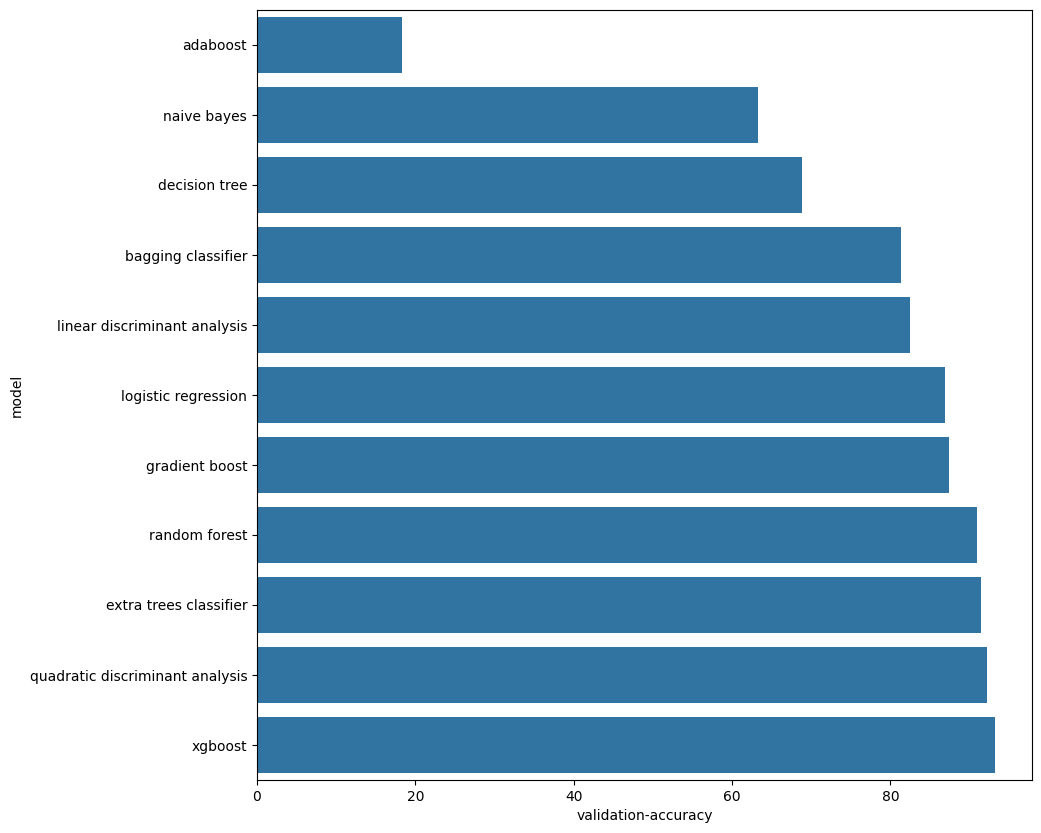

In [57]:
AutoLogger.get_metric_plot_classification(r,'validation','accuracy')

## Confusion Matrix

In [58]:
y_pred_ = aka_clean.swap_map(y_pred,swapMapping)
y_test_ = aka_clean.swap_map(y_test,swapMapping)
Label = [str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]

In [59]:
Label

['ambient',
 'big_room_house',
 'dnb',
 'dubstep',
 'future_garage_wave_trap',
 'hardcore',
 'hardstyle',
 'house',
 'lofi',
 'moombahton_reggaeton',
 'phonk',
 'psytrance',
 'synthwave',
 'techno',
 'trance',
 'trap']

In [60]:
shw = 1
fig2 =  aka_plot.plot_confusion_matrix(y_test_,y_pred_,Label,shw)
fig2.show()

## Classification Report

In [61]:
shw = 1
fig3 =  aka_plot.plot_classification_report(y_test_,y_pred_,Label,shw)
fig3.show()